In [72]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# cleaner plots
plt.style.use('seaborn-v0_8')


In [73]:
# Path to SQLite database
db_path = '/content/database.sqlite'

# database
conn = sqlite3.connect(db_path)

# top scorers csv
csv_path = '/content/top_scorers.final.csv'
top_scorers = pd.read_csv(csv_path)

# correct mergining
top_scorers['Team'] = top_scorers['Team'].str.strip()
top_scorers['Team'] = top_scorers['Team'].str.replace(r'\s+', ' ', regex=True)

name_map = {
    "Real Betis": "Real Betis Balompié",
    "Celta de Vigo": "RC Celta de Vigo",
    "Sporting Gijón": "Real Sporting de Gijón",
    "Athletic Club": "Athletic Club de Bilbao",
    "Deportivo La Coruña": "RC Deportivo de La Coruña",
    "Espanyol": "RCD Espanyol",
    "AC Milan": "Milan",
    "Chievo": "Chievo Verona"
}

top_scorers['Team'] = top_scorers['Team'].replace(name_map)


top_scorers.head()


,League,Season,Team,Top_Scorer,Top_Scorer_Goals
0,PL,2015/2016,Arsenal,Olivier Giroud,16
1,PL,2015/2016,Aston Villa,Jordan Ayew,7
2,PL,2015/2016,Bournemouth,Matt Ritchie,6
3,PL,2015/2016,Chelsea,Diego Costa,12
4,PL,2015/2016,Crystal Palace,Yohan Cabaye,5


In [74]:
db_path = '/content/database.sqlite'
conn = sqlite3.connect(db_path)


In [75]:
# tables in SQLite database
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)
tables


,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


In [76]:
# league IDs
league_ids = pd.read_sql_query("""
    SELECT id, name
    FROM League;
""", conn)

league_ids


,id,name
0,1,Belgium Jupiler League
1,1729,England Premier League
2,4769,France Ligue 1
3,7809,Germany 1. Bundesliga
4,10257,Italy Serie A
5,13274,Netherlands Eredivisie
6,15722,Poland Ekstraklasa
7,17642,Portugal Liga ZON Sagres
8,19694,Scotland Premier League
9,21518,Spain LIGA BBVA


In [77]:
# total team goals (home + away) for each league

def get_team_goals(league_id):
    query = f"""
        SELECT
            m.season,
            m.league_id,
            m.home_team_api_id AS team_id,
            SUM(m.home_team_goal) AS goals
        FROM Match m
        WHERE m.league_id = {league_id}
        GROUP BY m.season, m.home_team_api_id

        UNION ALL

        SELECT
            m.season,
            m.league_id,
            m.away_team_api_id AS team_id,
            SUM(m.away_team_goal) AS goals
        FROM Match m
        WHERE m.league_id = {league_id}
        GROUP BY m.season, m.away_team_api_id
    """

    df = pd.read_sql_query(query, conn)

    # total goals (inclduing home and away)
    df = df.groupby(['season', 'league_id', 'team_id'])['goals'].sum().reset_index()
    return df

# team goal totals for each league
goals_PL = get_team_goals(1729)
goals_SA = get_team_goals(10257)
goals_LL = get_team_goals(21518)

goals_PL.head()


,season,league_id,team_id,goals
0,2008/2009,1729,8455,68
1,2008/2009,1729,8456,58
2,2008/2009,1729,8462,38
3,2008/2009,1729,8472,34
4,2008/2009,1729,8528,34


In [78]:
# team names for merging
teams = pd.read_sql_query("""
    SELECT team_api_id, team_long_name
    FROM Team;
""", conn)

teams.head()


,team_api_id,team_long_name
0,9987,KRC Genk
1,9993,Beerschot AC
2,10000,SV Zulte-Waregem
3,9994,Sporting Lokeren
4,9984,KSV Cercle Brugge


In [79]:
# keep only 2015/2016 season
goals_PL_2016 = goals_PL[goals_PL['season'] == '2015/2016']
goals_LL_2016 = goals_LL[goals_LL['season'] == '2015/2016']
goals_SA_2016 = goals_SA[goals_SA['season'] == '2015/2016']

# merge team names into each league dataset
goals_PL_2016 = goals_PL_2016.merge(teams, left_on='team_id', right_on='team_api_id')
goals_LL_2016 = goals_LL_2016.merge(teams, left_on='team_id', right_on='team_api_id')
goals_SA_2016 = goals_SA_2016.merge(teams, left_on='team_id', right_on='team_api_id')

# keep relevant columns
goals_PL_2016 = goals_PL_2016[['team_long_name', 'goals']]
goals_LL_2016 = goals_LL_2016[['team_long_name', 'goals']]
goals_SA_2016 = goals_SA_2016[['team_long_name', 'goals']]

goals_PL_2016.head()


,team_long_name,goals
0,Leicester City,68
1,Chelsea,59
2,Manchester City,71
3,Southampton,59
4,Sunderland,48


In [80]:
# merge team name column
goals_PL_2016 = goals_PL_2016.rename(columns={'team_long_name': 'Team'})
goals_LL_2016 = goals_LL_2016.rename(columns={'team_long_name': 'Team'})
goals_SA_2016 = goals_SA_2016.rename(columns={'team_long_name': 'Team'})

# filter csv by league
csv_PL = top_scorers[top_scorers['League'] == 'PL']
csv_LL = top_scorers[top_scorers['League'] == 'La Liga']
csv_SA = top_scorers[top_scorers['League'] == 'Serie A']

# merge each league’s csv with its goal totals
merged_PL = csv_PL.merge(goals_PL_2016, on='Team', how='inner')
merged_LL = csv_LL.merge(goals_LL_2016, on='Team', how='inner')
merged_SA = csv_SA.merge(goals_SA_2016, on='Team', how='inner')

merged_PL.head()


,League,Season,Team,Top_Scorer,Top_Scorer_Goals,goals
0,PL,2015/2016,Arsenal,Olivier Giroud,16,65
1,PL,2015/2016,Aston Villa,Jordan Ayew,7,27
2,PL,2015/2016,Bournemouth,Matt Ritchie,6,45
3,PL,2015/2016,Chelsea,Diego Costa,12,59
4,PL,2015/2016,Crystal Palace,Yohan Cabaye,5,39


In [81]:
# calculation of team points for 2015/2016 season

def get_team_points(league_id):
    query = f"""
        SELECT
            season,
            league_id,
            home_team_api_id AS team_id,
            SUM(
                CASE
                    WHEN home_team_goal > away_team_goal THEN 3
                    WHEN home_team_goal = away_team_goal THEN 1
                    ELSE 0
                END
            ) AS points
        FROM Match
        WHERE league_id = {league_id}
        GROUP BY season, home_team_api_id

        UNION ALL

        SELECT
            season,
            league_id,
            away_team_api_id AS team_id,
            SUM(
                CASE
                    WHEN away_team_goal > home_team_goal THEN 3
                    WHEN away_team_goal = home_team_goal THEN 1
                    ELSE 0
                END
            ) AS points
        FROM Match
        WHERE league_id = {league_id}
        GROUP BY season, away_team_api_id
    """

    df = pd.read_sql_query(query, conn)
    df = df.groupby(['season', 'league_id', 'team_id'])['points'].sum().reset_index()
    return df

# retrieve points for each league
points_PL = get_team_points(1729)
points_LL = get_team_points(21518)
points_SA = get_team_points(10257)

# filter 2015/2016 season only
points_PL_2016 = points_PL[points_PL['season'] == '2015/2016']
points_LL_2016 = points_LL[points_LL['season'] == '2015/2016']
points_SA_2016 = points_SA[points_SA['season'] == '2015/2016']

# merge team names
points_PL_2016 = points_PL_2016.merge(teams, left_on='team_id', right_on='team_api_id')
points_LL_2016 = points_LL_2016.merge(teams, left_on='team_id', right_on='team_api_id')
points_SA_2016 = points_SA_2016.merge(teams, left_on='team_id', right_on='team_api_id')

# keep relevant columns
points_PL_2016 = points_PL_2016[['team_long_name', 'points']]
points_LL_2016 = points_LL_2016[['team_long_name', 'points']]
points_SA_2016 = points_SA_2016[['team_long_name', 'points']]

# reanming for merging consistency
points_PL_2016 = points_PL_2016.rename(columns={'team_long_name': 'Team'})
points_LL_2016 = points_LL_2016.rename(columns={'team_long_name': 'Team'})
points_SA_2016 = points_SA_2016.rename(columns={'team_long_name': 'Team'})

points_PL_2016.head()


,Team,points
0,Leicester City,81
1,Chelsea,50
2,Manchester City,66
3,Southampton,63
4,Sunderland,39


In [82]:
# merge goals + points for each league
final_PL = merged_PL.merge(points_PL_2016, on='Team', how='inner')
final_LL = merged_LL.merge(points_LL_2016, on='Team', how='inner')
final_SA = merged_SA.merge(points_SA_2016, on='Team', how='inner')

# dependence ratio
final_PL['Dependence_Ratio'] = final_PL['Top_Scorer_Goals'] / final_PL['goals']
final_LL['Dependence_Ratio'] = final_LL['Top_Scorer_Goals'] / final_LL['goals']
final_SA['Dependence_Ratio'] = final_SA['Top_Scorer_Goals'] / final_SA['goals']

final_PL.head()


,League,Season,Team,Top_Scorer,Top_Scorer_Goals,goals,points,Dependence_Ratio
0,PL,2015/2016,Arsenal,Olivier Giroud,16,65,71,0.246154
1,PL,2015/2016,Aston Villa,Jordan Ayew,7,27,17,0.259259
2,PL,2015/2016,Bournemouth,Matt Ritchie,6,45,42,0.133333
3,PL,2015/2016,Chelsea,Diego Costa,12,59,50,0.203390
4,PL,2015/2016,Crystal Palace,Yohan Cabaye,5,39,42,0.128205


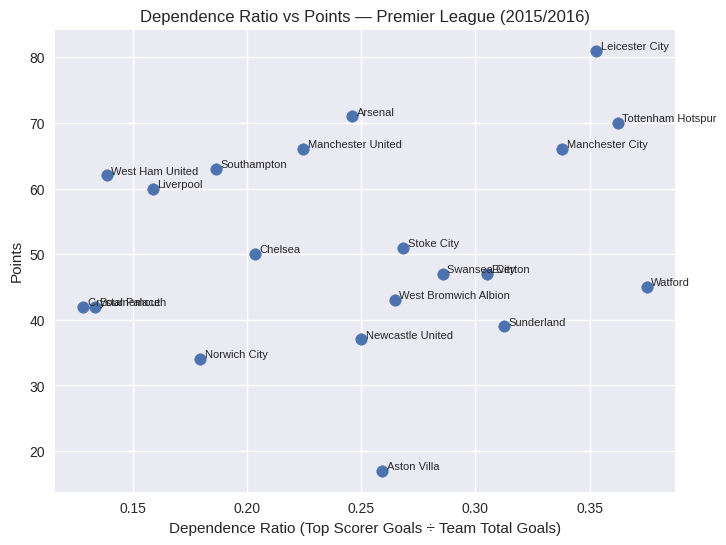

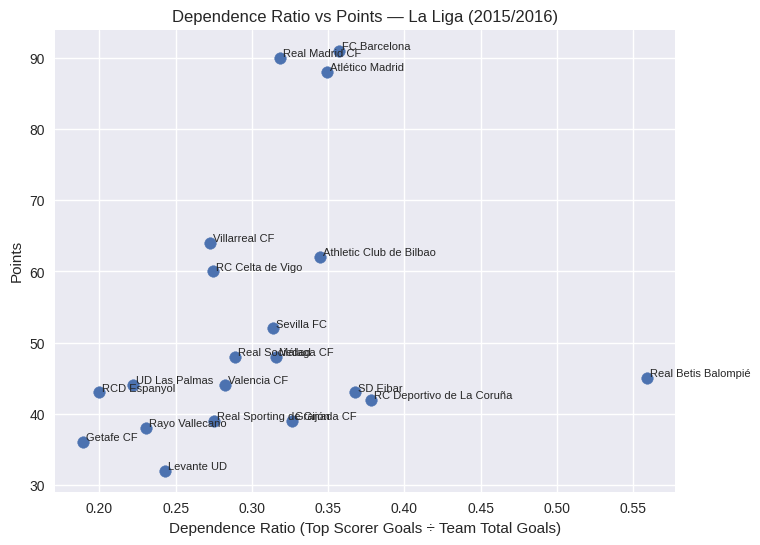

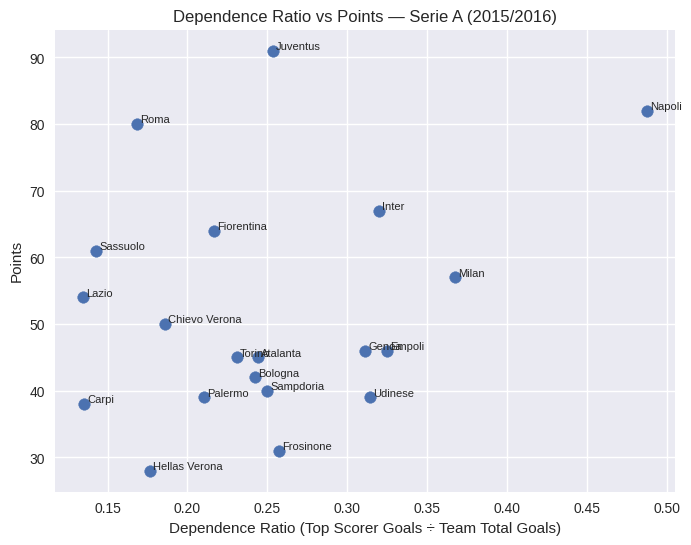

In [83]:
# scatter plots
def plot_league(df, league_name):
    plt.figure(figsize=(8,6))
    plt.scatter(df['Dependence_Ratio'], df['points'], s=70)

    for i in range(len(df)):
        plt.text(df['Dependence_Ratio'].iloc[i] + 0.002,
                 df['points'].iloc[i] + 0.2,
                 df['Team'].iloc[i],
                 fontsize=8)

    plt.title(f'Dependence Ratio vs Points — {league_name} (2015/2016)')
    plt.xlabel('Dependence Ratio (Top Scorer Goals ÷ Team Total Goals)')
    plt.ylabel('Points')
    plt.grid(True)
    plt.show()

plot_league(final_PL, "Premier League")
plot_league(final_LL, "La Liga")
plot_league(final_SA, "Serie A")







In [84]:
# correlation analysis

def correlation_report(df, league_name):
    corr = df['Dependence_Ratio'].corr(df['points'])
    print(f"{league_name} (2015/2016) — Correlation between Dependence Ratio and Points:")
    print(f"Correlation: {corr:.4f}\n")

correlation_report(final_PL, "Premier League")
correlation_report(final_LL, "La Liga")
correlation_report(final_SA, "Serie A")


Premier League (2015/2016) — Correlation between Dependence Ratio and Points:
Correlation: 0.1910

La Liga (2015/2016) — Correlation between Dependence Ratio and Points:
Correlation: 0.2465

Serie A (2015/2016) — Correlation between Dependence Ratio and Points:
Correlation: 0.2609



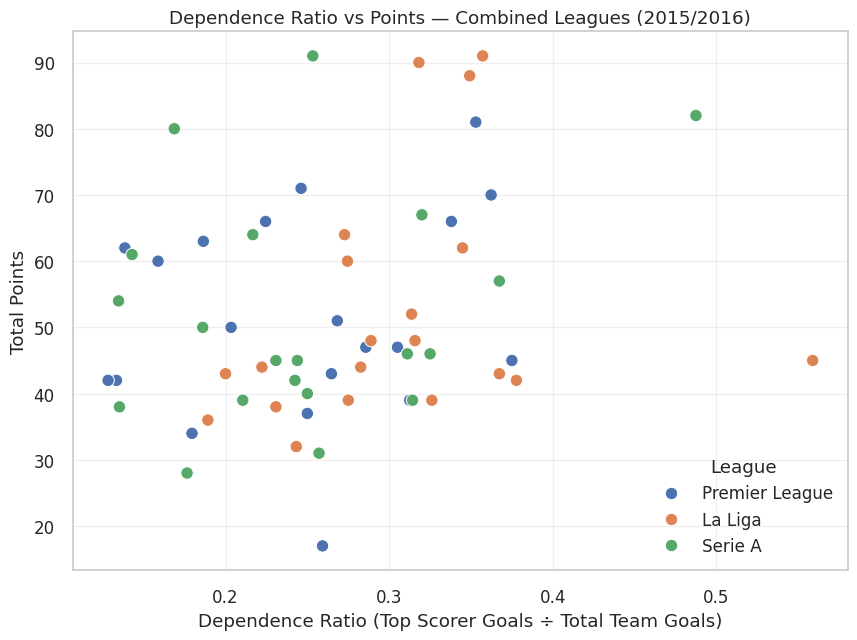

In [85]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=master_df,
    x="Dependence_Ratio",
    y="points",
    hue="League",
    palette="deep",
    s=80
)

plt.title("Dependence Ratio vs Points — Combined Leagues (2015/2016)")
plt.xlabel("Dependence Ratio (Top Scorer Goals ÷ Total Team Goals)")
plt.ylabel("Total Points")
plt.grid(True, alpha=0.3)

plt.legend(title="League")
plt.show()
